# Hands on Neural Networks with PyTorch (Part 2)
ACE Project - Agent-Based Modeling (ABM)

3/11/2024

## Import libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np

from torch.utils.data import Dataset, DataLoader, random_split
from tqdm.notebook import trange

import plotly.express as px

torch.manual_seed(50)

## Define a simple network

In [2]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(Net, self).__init__()
        self.layer1 = nn.Linear(in_channels, hidden_channels)
        self.layer2 = nn.Linear(hidden_channels, hidden_channels//2)
        self.layer3 = nn.Linear(hidden_channels//2, out_channels)
    
    def num_params(self):
        model_parameters = filter(lambda p: p.requires_grad, self.parameters())
        params = sum([np.prod(p.size()) for p in model_parameters])
        return params
    
    def forward(self, x):
        x = self.layer1(x)
        x = torch.relu(x)
        
        x = self.layer2(x)
        x = F.relu(x)
        
        x = self.layer3(x)
        x = F.relu(x)
        
        return x

## Dataset

### Define the DS type, inheriting from `Dataset` class from `PyTorch`:

In [3]:
class OurDataset(Dataset):
    def __init__(self, csv_dataset):
        df = pd.read_csv(csv_dataset)
        self.y = torch.tensor(df.values[:,-1], dtype=torch.long) - 1
        self.dataframe = (df-df.mean())/df.std()   # Normalization in order to get better performance
        self.x = torch.tensor(self.dataframe.values[:,:-1], dtype=torch.float32)

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

### [Fetal Health Dataset ](https://www.kaggle.com/datasets/andrewmvd/fetal-health-classification)

* Context

    Reduction of child mortality is reflected in several of the United Nations' Sustainable Development Goals and is a key indicator of human progress.
    The UN expects that by 2030, countries end preventable deaths of newborns and children under 5 years of age, with all countries aiming to reduce under‑5 mortality to at least as low as 25 per 1,000 live births.

    Parallel to notion of child mortality is of course maternal mortality, which accounts for 295 000 deaths during and following pregnancy and childbirth (as of 2017). The vast majority of these deaths (94%) occurred in low-resource settings, and most could have been prevented.

    In light of what was mentioned above, Cardiotocograms (CTGs) are a simple and cost accessible option to assess fetal health, allowing healthcare professionals to take action in order to prevent child and maternal mortality. The equipment itself works by sending ultrasound pulses and reading its response, thus shedding light on fetal heart rate (FHR), fetal movements, uterine contractions and more.


* Data

    This dataset contains 2126 records of features extracted from Cardiotocogram exams, which were then classified by three expert obstetritians into 3 classes:

   - Normal
   - Suspect
   - Pathological



In [4]:
dataset = OurDataset("fetal_health.csv")

## Training ...

### Prepare the test and the training set data

In [5]:
training_length = int(len(dataset) * 0.8)
test_length     = len(dataset) - training_length

training_indecies, test_indecies = random_split(dataset, [training_length, test_length])

training_input, training_labels  = dataset[training_indecies.indices]
test_input,     test_labels      = dataset[test_indecies.indices]

### Initialize the model, Optimizer and Loss function

In [6]:
net = Net(21, 32, 3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)

### Train/Test the model with training/test set

In [7]:
train_loss_arr = []
test_acc_arr   = []

for epoch in trange(500,desc=f"Training ...", unit='Epoch'):  # loop over the dataset multiple times

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net(training_input)
    loss = criterion(outputs, training_labels)
    loss.backward()
    optimizer.step()

    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        # calculate outputs by running images through the network
        outputs = net(test_input)
        # the class with the highest energy is what we choose as prediction
        predicted = outputs.argmax(dim=1)
        correct += (predicted == test_labels).sum().item()
    
    acc      = 100 * correct / test_length
    loss_val = loss.item()
    
    train_loss_arr.append(loss_val)
    test_acc_arr.append(acc)
    
    if epoch % 20 == 19:
        print(f'epoch {epoch + 1: 04d}; loss: {loss_val: 0.4f}; Accuracy on test: {acc: 0.4f} %')

print('Finished Training')

Training ...:   0%|          | 0/500 [00:00<?, ?Epoch/s]

epoch  020; loss:  0.8151; Accuracy on test:  86.3850 %
epoch  040; loss:  0.2770; Accuracy on test:  88.7324 %
epoch  060; loss:  0.2101; Accuracy on test:  91.3146 %
epoch  080; loss:  0.1655; Accuracy on test:  92.0188 %
epoch  100; loss:  0.1247; Accuracy on test:  91.7840 %
epoch  120; loss:  0.0935; Accuracy on test:  91.5493 %
epoch  140; loss:  0.0708; Accuracy on test:  91.5493 %
epoch  160; loss:  0.0530; Accuracy on test:  92.7230 %
epoch  180; loss:  0.0409; Accuracy on test:  92.4883 %
epoch  200; loss:  0.0329; Accuracy on test:  92.9577 %
epoch  220; loss:  0.0264; Accuracy on test:  92.7230 %
epoch  240; loss:  0.0214; Accuracy on test:  92.7230 %
epoch  260; loss:  0.0177; Accuracy on test:  92.2535 %
epoch  280; loss:  0.0149; Accuracy on test:  93.1925 %
epoch  300; loss:  0.0130; Accuracy on test:  92.9577 %
epoch  320; loss:  0.0115; Accuracy on test:  92.9577 %
epoch  340; loss:  0.0103; Accuracy on test:  93.1925 %
epoch  360; loss:  0.0094; Accuracy on test:  93

## Visulizing the results

### Test Accuracy; Very Good!

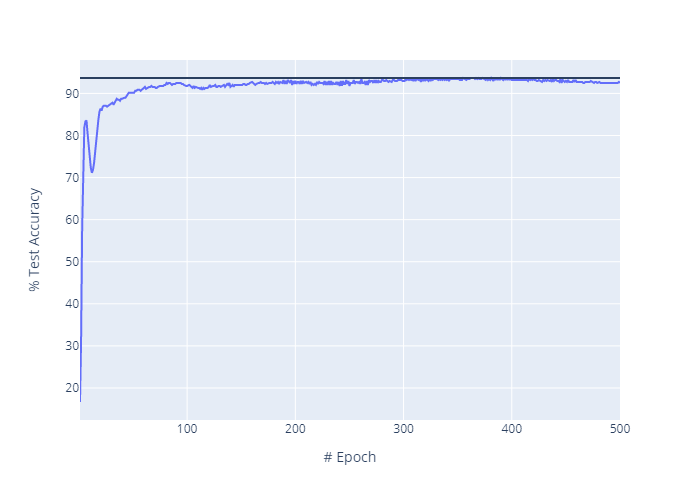

In [8]:
fig = px.line(x=list(range(1,501)), y=test_acc_arr)
fig.update_xaxes(title="# Epoch")
fig.update_yaxes(title="% Test Accuracy")
fig.add_hline(max(test_acc_arr))
fig.show(renderer='png')

### Training Loss: Excellent!

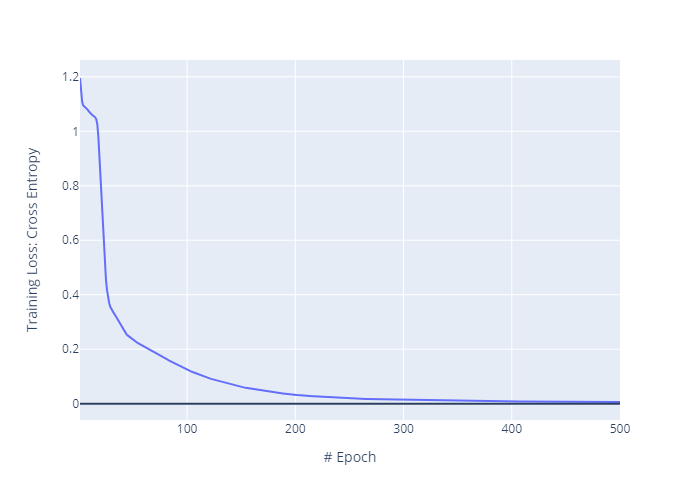

In [9]:
fig = px.line(x=list(range(1,501)), y=train_loss_arr)
fig.update_xaxes(title="# Epoch")
fig.update_yaxes(title=f"Training Loss: Cross Entropy")
fig.add_hline(0)
fig.show(renderer='png')

## To Do:
    1. What is the overfitting/overfitting regime?
    2. At which epoch does the model enter the overfitting regime?
    3. How can we avoid overfitting/underfitting in Neural Networks?
    4. What is over-parametrization technique in modern deep learning?
    5. Do we enter in over-parametrization regime in this problem? 
   * Hint: you can find the number of trainable parameters of the model using `num_params` method
   
    6. Add a few lines of codes to save the best trained model before going to overfitting regime.
   * Hint: The answer of the 2nd question can help.
